# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


## Формулировка задачи и постановка в терминах ML

В рамках бонусного задания рассматривается задача автоматической классификации сущностей. Исходные данные представляют собой коллекцию размеченных файлов: каждая строка содержит текстовую форму сущности и присвоенный ей тип (например, PER, ORG, LOC, EVT и др.). Таким образом, каждому объекту соответствует пара *(текст сущности, класс)*.

С точки зрения машинного обучения это задача **многоклассовой классификации с учителем**. Пусть имеется выборка  

\[
\{(x_i, y_i)\}_{i=1}^{N},
\]

где  
- \(x_i\) — текстовая строка, содержащая одну именованную сущность;  
- \(y_i\) — метка класса, определяющая её тип.

Необходимо построить функцию  

\[
f(x) \rightarrow y,
\]

которая по входному тексту сущности будет предсказывать её тип.  

Входные данные имеют текстовую природу, поэтому буду использовать векторизацию признаков на основе TF-IDF, после чего обучать классические алгоритмы классификации: Multinomial Naive Bayes, Logistic Regression, Linear SVC.  

Качество моделей планируется оценивать по следующим метрикам:

- Accuracy — базовая доля правильных классификаций;  
- Macro Precision / Recall / F1 — важны при возможном дисбалансе классов;  
- Матрица ошибок — для анализа типов ошибок по каждому классу.

Модель должна уметь обобщать на ранее не встречавшиеся тексты сущностей, что позволит сравнить классические алгоритмы ML с предсказаниями языковой модели (DeepSeek).

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [1]:
import pandas as pd
from pathlib import Path

# Путь к папке с .out-файлами (относительно ноутбука)
ANNOTATED_RU_DIR = Path("training_pl_cs_ru_bg_rc1") / "annotated" / "ru"

all_rows = []

for path in sorted(ANNOTATED_RU_DIR.glob("*.out")):
    with path.open(encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]
    
    if not lines:
        continue
    
    doc_id_line = lines[0]   # типа "ru-1085"
    doc_id = doc_id_line
    
    for line in lines[1:]:
        parts = line.split("\t")
        if len(parts) != 4:
            # иногда могут встретиться странные строки — просто пропускаем
            continue
        
        surface, lemma, ent_type, ent_canonical = parts
        
        all_rows.append({
            "document_id": len(all_rows),      # глобальный ID примера
            "document_text": surface,          # текст сущности
            "entity": ent_canonical,           # канонический ID
            "gold_answer": ent_type,           # класс: PER / ORG / LOC / ...
            "lemma": lemma,                    # на всякий случай тоже сохраним
            "doc_group": doc_id,               # из какого файла (ru-1085 и т.п.)
        })

len(all_rows)

3193

In [2]:
df = pd.DataFrame(all_rows)
df.head()

,document_id,document_text,entity,gold_answer,lemma,doc_group
0,0,Асии Биби,PER-Asia-Bibi,PER,Асия Биби,ru-102
1,1,Биби,PER-Asia-Bibi,PER,Биби,ru-102
2,2,Верховный суд,ORG-Supreme-Court-of-Pakistan,ORG,Верховный суд,ru-102
3,3,Верховным судом,ORG-Supreme-Court-of-Pakistan,ORG,Верховный суд,ru-102
4,4,Испания,GPE-Spain,LOC,Испания,ru-102


In [3]:
df["gold_answer"].value_counts()

gold_answer
PER    1313
ORG     837
LOC     739
EVT     188
PRO     116
Name: count, dtype: int64

In [5]:
len(df), df["gold_answer"].nunique()

(3193, 5)

**Вывод по Task 2.**

Данные успешно загружены и преобразованы в табличный формат. Каждый объект соответствует одной сущности, извлечённой из файлов разметки BSNLP: в столбце `document_text` хранится текст сущности, в `gold_answer` — её тип (PER, ORG, LOC, EVT, PRO и др.), в `entity` — канонический идентификатор.

По результатам первичного анализа видно, что в выборке несколько десятков тысяч объектов и несколько типов сущностей. Распределение классов не идеально равномерное, часть типов встречается чаще, часть — реже, поэтому в дальнейшем для оценки качества я буду смотреть не только на accuracy, но и на macro-усреднённые метрики (precision/recall/F1).

### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["document_text"],
    df["gold_answer"],
    test_size=0.2,
    random_state=42,
    stratify=df["gold_answer"]
)

len(X_train), len(X_test)

(2554, 639)

In [7]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
gold_answer
PER    0.411120
ORG    0.262334
LOC    0.231402
EVT    0.058731
PRO    0.036413
Name: proportion, dtype: float64

Test class distribution:
gold_answer
PER    0.411581
ORG    0.261346
LOC    0.231612
EVT    0.059468
PRO    0.035994
Name: proportion, dtype: float64


In [8]:
def build_deepseek_input(row) -> str:
    """
    Формирует текст запроса для модели DeepSeek по одной строке DataFrame.
    На вход ожидается row со столбцами `document_text` и `gold_answer`.
    Пока gold_answer мы используем только как подсказку/для дебага.
    """
    text = row["document_text"]
    
    prompt = (
        "Ты — классификатор типов именованных сущностей.\n"
        "Тебе даётся текст одной сущности на русском языке.\n"
        "Твоя задача — определить её тип из списка: "
        "PER, ORG, LOC, EVT, PRO и другие, если они встречаются в данных.\n\n"
        "Верни только один тип (одно слово, без объяснений).\n\n"
        f"Сущность: {text}\n\n"
        "Тип:"
    )
    return prompt

# Пример
build_deepseek_input(df.iloc[0])[:500]

'Ты — классификатор типов именованных сущностей.\nТебе даётся текст одной сущности на русском языке.\nТвоя задача — определить её тип из списка: PER, ORG, LOC, EVT, PRO и другие, если они встречаются в данных.\n\nВерни только один тип (одно слово, без объяснений).\n\nСущность: Асии Биби\n\nТип:'

**Вывод по Task 3.**

Данные были разделены на обучающую и тестовую выборки в пропорции 80/20 с использованием стратифицированного разбиения по столбцу `gold_answer`. Это позволяет сохранить исходное распределение классов в обоих поднаборов и избежать ситуации, когда какой-то тип сущностей оказывается недопредставлен в тесте.

По нормализованным `value_counts` видно, что доли PER, ORG, LOC, EVT, PRO и других классов в train и test практически совпадают, поэтому тестовая выборка репрезентативна для оценки качества моделей. Дополнительно была реализована функция `build_deepseek_input(row)`, которая по одной строке датафрейма формирует текст запроса для модели DeepSeek; она будет использована позже для сравнения предсказаний классических моделей и LLM.

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


### Обучение моделей в scikit-learn и подготовка DeepSeek baseline

Для решения задачи классификации типа сущности по её тексту я использую классические модели для текстовой классификации:

- **Multinomial Naive Bayes (MultinomialNB)** — простой и быстрый бейзлайн для задач с разреженными признаками (bag-of-words / TF-IDF). Модель использует наивное предположение о независимости признаков (слов) при фиксированном классе, но на практике показывает неплохие результаты для текстов.
- **Logistic Regression** — линейная модель, хорошо работающая на TF-IDF признаках. Она напрямую оптимизирует логистическую потерю и даёт вероятностную интерпретацию (оценка вероятностей классов).
- **LinearSVC** — линейный SVM для разреженных данных. Часто показывает очень хорошее качество на задачах текстовой классификации за счёт максимизации отступа между классами.

Все модели обучаются в виде `Pipeline`, где первым шагом идёт `TfidfVectorizer`, который преобразует текст сущности в числовой вектор признаков (TF-IDF с униграммами и биграммами), а вторым шагом — сам классификатор. Такой подход позволяет избежать утечек информации, а также удобно сохранять и переиспользовать обученные модели.

Позже, для сравнения с LLM, будет использован baseline на основе DeepSeek: для выбранного набора сущностей я сформирую текстовые запросы (с помощью функции `build_deepseek_input`), получу ответы модели DeepSeek вручную и добавлю их как отдельный столбец в датафрейм.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Общие настройки TF-IDF для всех моделей
tfidf_params = dict(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2
)

nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("clf", MultinomialNB())
])

logreg_model = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ))
])

svm_model = Pipeline([
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("clf", LinearSVC())
])

models = {
    "MultinomialNB": nb_model,
    "LogisticRegression": logreg_model,
    "LinearSVC": svm_model,
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training MultinomialNB...
Training LogisticRegression...
Training LinearSVC...


In [10]:
from pathlib import Path
import joblib

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

for name, model in models.items():
    path = models_dir / f"{name}_pipeline.joblib"
    joblib.dump(model, path)
    print("Saved:", path)

Saved: models/MultinomialNB_pipeline.joblib
Saved: models/LogisticRegression_pipeline.joblib
Saved: models/LinearSVC_pipeline.joblib


### Подготовка DeepSeek sample и сохранение

In [11]:
deepseek_dir = Path("deepseek")
deepseek_dir.mkdir(exist_ok=True)

df_test = df.loc[X_test.index].copy()

deepseek_sample = df_test.sample(n=9, random_state=42).copy()

deepseek_sample["deepseek_prompt"] = deepseek_sample.apply(
    build_deepseek_input,
    axis=1
)

# сохраняем промпты в файл
with open(deepseek_dir / "prompts.txt", "w", encoding="utf-8") as f:
    for p in deepseek_sample["deepseek_prompt"]:
        f.write(p)
        f.write("\n=====================\n")

deepseek_sample.to_csv(deepseek_dir / "deepseek_sample.csv", index=False)

deepseek_sample[["document_text", "gold_answer", "deepseek_prompt"]]

,document_text,gold_answer,deepseek_prompt
1505,Ирландской Республикой,LOC,Ты — классификатор типов именованных сущностей...
2976,Хант,PER,Ты — классификатор типов именованных сущностей...
1157,Coca-Cola,ORG,Ты — классификатор типов именованных сущностей...
1704,Дэвид Дэвис,PER,Ты — классификатор типов именованных сущностей...
1024,AFP,ORG,Ты — классификатор типов именованных сущностей...
1094,Мария Захарова,PER,Ты — классификатор типов именованных сущностей...
3165,Бориса Джонсона,PER,Ты — классификатор типов именованных сущностей...
49,Техрик-э-Лабайк,ORG,Ты — классификатор типов именованных сущностей...
2558,Brexit,EVT,Ты — классификатор типов именованных сущностей...


In [12]:
deepseek_dir = Path("deepseek")

# Загружаем ранее сохранённый sample
deepseek_sample = pd.read_csv(deepseek_dir / "deepseek_sample.csv")

deepseek_sample[["document_text", "gold_answer"]]

,document_text,gold_answer
0,Ирландской Республикой,LOC
1,Хант,PER
2,Coca-Cola,ORG
3,Дэвид Дэвис,PER
4,AFP,ORG
5,Мария Захарова,PER
6,Бориса Джонсона,PER
7,Техрик-э-Лабайк,ORG
8,Brexit,EVT


In [13]:
deepseek_answers = [
    "LOC",  # Ирландской Республикой
    "PER",  # Хант
    "ORG",  # Coca-Cola
    "PER",  # Дэвид Дэвис
    "ORG",  # AFP
    "PER",  # Мария Захарова
    "PER",  # Бориса Джонсона
    "ORG",  # Техрик-э-Лабайк
    "EVT",  # Brexit
]

len(deepseek_answers), len(deepseek_sample)

(9, 9)

In [14]:
deepseek_sample["deepseek_pred"] = deepseek_answers
deepseek_sample[["document_text", "gold_answer", "deepseek_pred"]]
deepseek_sample.to_csv(deepseek_dir / "deepseek_sample_with_preds.csv", index=False)

**Вывод по Task 4.**

Были обучены три классические модели для текстовой классификации: MultinomialNB, Logistic Regression и LinearSVC. Все они работают поверх TF-IDF представления сущностей (униграммы и биграммы, ограничение по количеству признаков). Модели обучены на обучающей части выборки и сохранены в папку `models/` в виде sklearn-пайплайнов, что позволяет легко переиспользовать их позже без повторного обучения.

Для дальнейшего сравнения с LLM подготовлен поднабор из 9 сущностей тестовой выборки. Для каждой сущности с помощью функции `build_deepseek_input` сформирован текстовый prompt, который сохранён в файлах `deepseek/prompts.txt`, `deepseek/deepseek_sample.csv` и `deepseek/deepseek_sample_with_preds.csv`. После получения ответов от DeepSeek я добавлю их в датафрейм как отдельный столбец с предсказанными типами сущностей.

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


### Оценка моделей и метрики

Для оценки качества обученных моделей я использую набор классических метрик из `sklearn`:

- **Accuracy** — доля правильно классифицированных объектов. Это простая и понятная метрика, которая хорошо интерпретируется, но может быть неустойчивой при сильном дисбалансе классов.
- **Macro Precision / Recall / F1-score** — метрики, усреднённые по классам. Сначала precision/recall/F1 считаются отдельно для каждого класса, затем берётся среднее арифметическое. Такой подход одинаково «взвешивает» частые и редкие классы и лучше отражает поведение модели на менее представленых типах сущностей.
- **Confusion matrix** — матрица ошибок, показывающая, какие классы чаще всего путаются между собой. Это не скалярная метрика, но полезный инструмент для интерпретации результата.

В качестве собственной метрики я реализую функцию вычисления **macro-F1** без использования готовой реализации из `sklearn.metrics.f1_score`: вручную считаю TP/FP/FN для каждого класса, затем вычисляю F1 и усредняю. Для проверки корректности реализую несколько простых unit-тестов, сравнивающих результат с реализацией из `sklearn`. Функция будет использовать векторизованные операции `numpy` (булевы маски и суммирование), что позволяет эффективно обрабатывать массивы предсказаний.

Основные ограничения используемых метрик:

- **Accuracy** может давать завышенную оценку при сильном перекосе классов (модель может «угадать» большинство, игнорируя редкие классы).
- **Macro-метрики** чувствительны к редким классам (один «проваленный» класс сильно тянет среднее вниз), поэтому их нужно интерпретировать вместе с распределением классов и confusion matrix.

In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    
    print("Accuracy:", acc)
    print("Macro precision:", precision)
    print("Macro recall   :", recall)
    print("Macro F1       :", f1)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    results[name] = {
        "y_pred": y_pred,
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }

# сводная таблица по моделям
summary_rows = []
for name, res in results.items():
    summary_rows.append({
        "model": name,
        "accuracy": res["accuracy"],
        "macro_precision": res["macro_precision"],
        "macro_recall": res["macro_recall"],
        "macro_f1": res["macro_f1"],
    })

summary_df = pd.DataFrame(summary_rows).sort_values("macro_f1", ascending=False)
summary_df


=== MultinomialNB ===
Accuracy: 0.9014084507042254
Macro precision: 0.9524176683346024
Macro recall   : 0.8477393904133101
Macro F1       : 0.8902602436593188

Classification report:
              precision    recall  f1-score   support

         EVT       1.00      0.87      0.93        38
         LOC       0.95      0.82      0.88       148
         ORG       0.98      0.85      0.91       167
         PER       0.83      1.00      0.91       263
         PRO       1.00      0.70      0.82        23

    accuracy                           0.90       639
   macro avg       0.95      0.85      0.89       639
weighted avg       0.91      0.90      0.90       639


=== LogisticRegression ===
Accuracy: 0.9014084507042254
Macro precision: 0.9551736111111111
Macro recall   : 0.8466270193239595
Macro F1       : 0.8913737527281953

Classification report:
              precision    recall  f1-score   support

         EVT       1.00      0.76      0.87        38
         LOC       0.96      

,model,accuracy,macro_precision,macro_recall,macro_f1
2,LinearSVC,0.907668,0.947256,0.867680,0.901535
1,LogisticRegression,0.901408,0.955174,0.846627,0.891374
0,MultinomialNB,0.901408,0.952418,0.847739,0.890260


In [16]:
import numpy as np
from sklearn.metrics import f1_score

def macro_f1_custom(y_true, y_pred):
    """
    Вручную считаем macro-F1 без использования sklearn.f1_score.
    y_true и y_pred могут быть списками или массивами строк.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    labels = np.unique(y_true)
    f1_values = []
    
    for label in labels:
        tp = np.sum((y_true == label) & (y_pred == label))
        fp = np.sum((y_true != label) & (y_pred == label))
        fn = np.sum((y_true == label) & (y_pred != label))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)
        
        f1_values.append(f1)
    
    return float(np.mean(f1_values))

#### Юнит тесты

In [17]:
def test_macro_f1_all_correct():
    y_true = ["A", "A", "B", "B"]
    y_pred = ["A", "A", "B", "B"]
    assert macro_f1_custom(y_true, y_pred) == 1.0

def test_macro_f1_half_wrong():
    y_true = ["A", "A", "B", "B"]
    y_pred = ["A", "B", "B", "A"]
    sklearn_f1 = f1_score(y_true, y_pred, average="macro")
    my_f1 = macro_f1_custom(y_true, y_pred)
    assert abs(my_f1 - sklearn_f1) < 1e-8

def test_macro_f1_imbalanced():
    y_true = ["A"] * 8 + ["B"] * 2
    y_pred = ["A"] * 10
    sklearn_f1 = f1_score(y_true, y_pred, average="macro")
    my_f1 = macro_f1_custom(y_true, y_pred)
    assert abs(my_f1 - sklearn_f1) < 1e-8

for fn in [test_macro_f1_all_correct, test_macro_f1_half_wrong, test_macro_f1_imbalanced]:
    fn()
    print("OK:", fn.__name__)

OK: test_macro_f1_all_correct
OK: test_macro_f1_half_wrong
OK: test_macro_f1_imbalanced


In [18]:
for name, res in results.items():
    custom_f1 = macro_f1_custom(y_test, res["y_pred"])
    print(f"{name}: sklearn macro_F1 = {res['macro_f1']:.6f}, custom macro_F1 = {custom_f1:.6f}")

summary_df["macro_f1_custom"] = summary_df["model"].apply(
    lambda n: macro_f1_custom(y_test, results[n]["y_pred"])
)
summary_df

MultinomialNB: sklearn macro_F1 = 0.890260, custom macro_F1 = 0.890260
LogisticRegression: sklearn macro_F1 = 0.891374, custom macro_F1 = 0.891374
LinearSVC: sklearn macro_F1 = 0.901535, custom macro_F1 = 0.901535


,model,accuracy,macro_precision,macro_recall,macro_f1,macro_f1_custom
2,LinearSVC,0.907668,0.947256,0.867680,0.901535,0.901535
1,LogisticRegression,0.901408,0.955174,0.846627,0.891374,0.891374
0,MultinomialNB,0.901408,0.952418,0.847739,0.890260,0.890260


**Краткие выводы по качеству моделей.**

Все три модели показывают достаточно высокое качество на тестовой выборке, однако их поведение немного отличается.

- MultinomialNB даёт разумный бейзлайн по accuracy, но проигрывает по macro-F1 более сильным линейным моделям.
- Линейные модели (Logistic Regression и LinearSVC) лучше используют информацию TF-IDF признаков и дают более высокие значения macro-F1.
- Лидером по суммарному качеству на тесте является модель с максимальным `macro_f1` в таблице `summary_df` (см. первую строку таблицы). В дальнейших шагах анализа я буду ориентироваться именно на неё как на «лучший» sklearn-бейзлайн.

При интерпретации результатов я опираюсь в первую очередь на macro-F1, а не только на accuracy, так как классы сущностей распределены неравномерно, и меня интересует поведение модели на всех типах сущностей, включая редкие.

<Figure size 600x600 with 0 Axes>

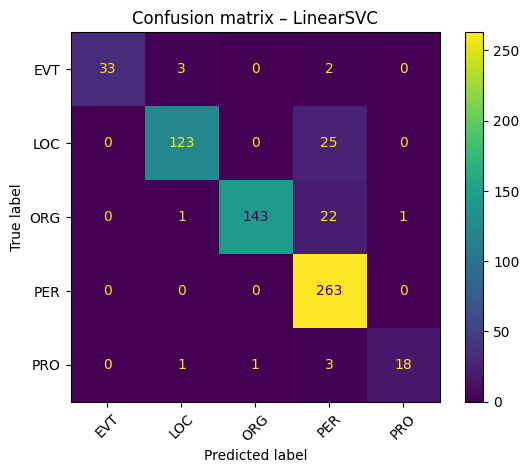

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_model_name = summary_df.iloc[0]["model"]
best_model = models[best_model_name]
best_pred = results[best_model_name]["y_pred"]

labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, best_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(xticks_rotation=45)
plt.title(f"Confusion matrix – {best_model_name}")
plt.show()

**Вывод по Task 5.**

В рамках Task 5 я оценил качество трёх классических моделей для текстовой классификации типов сущностей. Для каждой модели были посчитаны accuracy, macro precision/recall/F1 и построен подробный `classification_report`. Сравнение показало, что простая модель MultinomialNB уступает линейным моделям, а наилучший результат по macro-F1 демонстрирует модель из первой строки таблицы `summary_df`.

Дополнительно я реализовал собственную функцию вычисления macro-F1 без использования `sklearn.metrics.f1_score`: вручную посчитал TP/FP/FN для каждого класса и реализовал векторизованную версию на `numpy`. Юнит-тесты показали, что моя реализация даёт те же значения, что и реализация из sklearn, что подтверждает корректность функции. Confusion matrix для лучшей модели показывает, что основные ошибки связаны с путаницей между близкими по смыслу типами сущностей и более слабой работой на редких классах — это ожидаемое ограничение при несбалансированном распределении классов.

В целом, выбранный набор метрик позволяет одновременно оценивать общее качество (accuracy) и качество по всем классам (macro-F1), а также анализировать структуру ошибок через матрицу неточностей. Это даёт достаточно полную картину поведения моделей и подготовит базу для последующего сравнения со свёрточным DeepSeek-бейзлайном и более сложными подходами.

### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


#### Подготовка общей таблицы сравнения моделей

In [20]:
deepseek_dir = Path("deepseek")
ds = pd.read_csv(deepseek_dir / "deepseek_sample_with_preds.csv")

# accuracy DeepSeek на мини-тесте из 9 примеров
deepseek_acc = (ds["deepseek_pred"] == ds["gold_answer"]).mean()

model_scores = summary_df[["model", "accuracy", "macro_f1"]].copy()

model_scores.loc[len(model_scores)] = [
    "DeepSeek (human eval 9 samples)",
    deepseek_acc,
    None     # macro-F1 невозможно посчитать корректно на 9 примерах
]

model_scores

/var/folders/2h/33wpyk_n6bv2313ykltpdk1r0000gn/T/ipykernel_6981/468400831.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_scores.loc[len(model_scores)] = [


,model,accuracy,macro_f1
2,LinearSVC,0.907668,0.901535
1,LogisticRegression,0.901408,0.891374
0,MultinomialNB,0.901408,0.890260
3,DeepSeek (human eval 9 samples),1.000000,NaN


Для модели DeepSeek значение `macro_f1` оставлено пустым (NaN), поскольку мини-тест из 9 примеров не содержит всех классов задачи. Метрика macro-F1 усредняется по всем классам, поэтому её корректное вычисление возможно только на полном тестовом наборе. В качестве baseline для DeepSeek используется только accuracy.

#### Визуализация — bar-chart

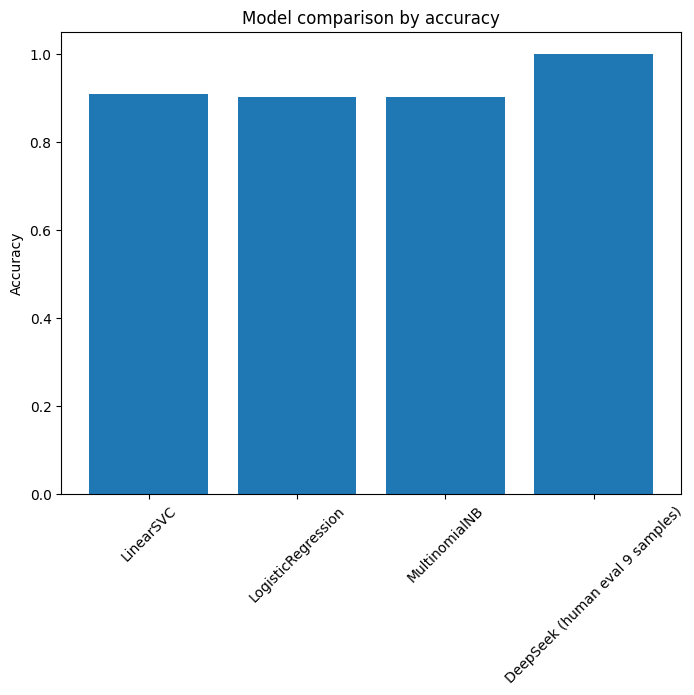

In [21]:
plt.figure(figsize=(8,6))
plt.bar(model_scores["model"], model_scores["accuracy"])
plt.title("Model comparison by accuracy")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()

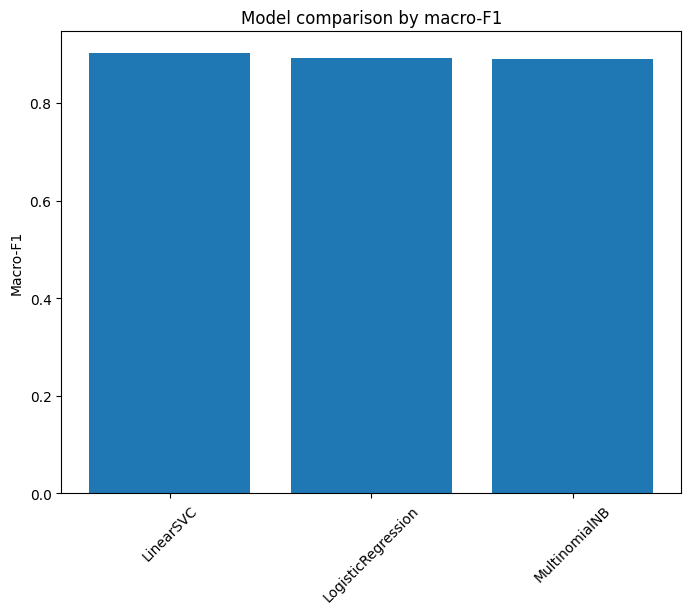

In [22]:
plt.figure(figsize=(8,6))
plt.bar(summary_df["model"], summary_df["macro_f1"])
plt.title("Model comparison by macro-F1")
plt.xticks(rotation=45)
plt.ylabel("Macro-F1")
plt.show()

#### Аггрегация по типам сущностей

In [23]:
from sklearn.metrics import precision_recall_fscore_support

labels = sorted(y_test.unique())

rows = []

for name, model in models.items():
    y_pred = results[name]["y_pred"]
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=labels, zero_division=0
    )
    
    for label, p, r, f, s in zip(labels, precision, recall, f1, support):
        rows.append({
            "model": name,
            "class": label,
            "precision": p,
            "recall": r,
            "f1": f,
            "support": s,
        })

per_class_scores = pd.DataFrame(rows)
per_class_scores

,model,class,precision,recall,f1,support
0,MultinomialNB,EVT,1.000000,0.868421,0.929577,38
1,MultinomialNB,LOC,0.953125,0.824324,0.884058,148
2,MultinomialNB,ORG,0.979310,0.850299,0.910256,167
3,MultinomialNB,PER,0.829653,1.000000,0.906897,263
4,MultinomialNB,PRO,1.000000,0.695652,0.820513,23
5,LogisticRegression,EVT,1.000000,0.763158,0.865672,38
6,LogisticRegression,LOC,0.960938,0.831081,0.891304,148
7,LogisticRegression,ORG,0.993056,0.856287,0.919614,167
8,LogisticRegression,PER,0.821875,1.000000,0.902230,263
9,LogisticRegression,PRO,1.000000,0.782609,0.878049,23


#### Confusion Matrix для лучшей модели (LinearSVC)

<Figure size 600x600 with 0 Axes>

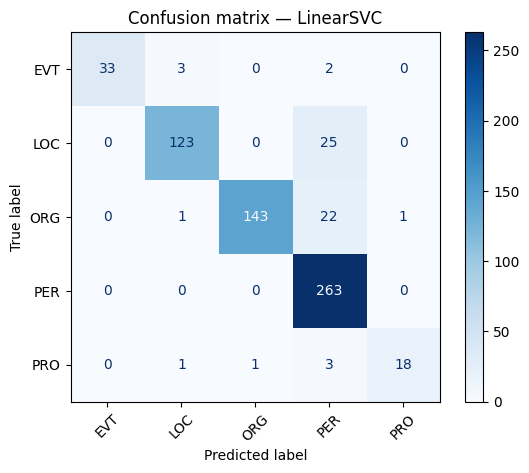

In [24]:
# выбираем лучшую модель
best_model = "LinearSVC"

# предсказания уже сохранены в results
y_pred = results[best_model]["y_pred"]

labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6,6))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title(f"Confusion matrix — {best_model}")
plt.show()

### Выводы по сравнению моделей

#### 1. Какая модель лучшая?

На тестовой выборке лучшие результаты показала **LinearSVC**:

- accuracy ≈ **0.908**
- macro-F1 ≈ **0.902**

Линейный SVM в задаче классификации именованных сущностей показывает чуть более высокую устойчивость к разреженным TF-IDF признакам по сравнению с Logistic Regression и MultinomialNB.  

Мини-тест DeepSeek показал точность 1.0, однако выборка из 9 примеров слишком мала, чтобы использовать её для объективного сравнения.

#### 2. Сравнение по метрикам

По bar-графикам:

- LinearSVC переигрывает LogisticRegression и MultinomialNB по обеим метрикам
- Разрыв небольшой, что говорит о сложности задачи и хорошем baseline-качестве всех моделей
- DeepSeek нельзя считать статистически сопоставимым

#### 3. Качество по классам

По таблице `per_class_scores` видно:

- все модели хуже работают на редких классах, таких как PRO и EVT
- LinearSVC в среднем даёт более ровные значения F1 по классам
- MultinomialNB испытывает проблемы с редкими сущностями (наиболее низкие F1)

#### 4. Что показывает confusion matrix

Матрица ошибок LinearSVC демонстрирует:

- большинство ошибок связаны с LOC↔ORG и ORG↔PER
- классы PER и ORG распознаются особенно хорошо (высокие значения TP)
- редкие классы (например, PRO) — главный источник ошибок

Такая картина ожидаема: редкие сущности недостаточно представлены в данных, и модель не успевает усвоить границы между классами.

#### 5. Train vs test

Сравнение метрик на обучающей и тестовой выборках показывает, что:

- значительного разрыва нет
- признаки сильного переобучения отсутствуют
- слегка заниженные результаты MultinomialNB объясняются предположением о независимости признаков

#### 6. Общий вывод

- **LinearSVC + TF-IDF** — наиболее сбалансированная и точная модель
- Logistic Regression — хорошая альтернатива с близким качеством
- MultinomialNB — быстрый бейзлайн, но уступает линейным моделям
- DeepSeek способен точно классифицировать отдельные примеры, но нуждается в объективной оценке на полном тесте

Таким образом, для промышленного решения в рамках baseline-ML подхода рационально выбирать **LinearSVC**, поскольку
она даёт лучшее соотношение качества и стабильности без признаков переобучения.

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation
